# Homework 1
## by Ivan Gurev
## for the course "Models of sequential data"

We will consider the estimation for MA model for a particular dataset.
There are 5 problems in this homework.
* The first 4 problems are obligatory.
* You can earn bonus points by making progress on the problem 5.

You have two weeks to complete the homework. The strict deadline is **23:59 $25$th of September, Moscow time**.
No points will be awarded for the homework submitted after the deadline.


The name of the notebook should be in format *msd_hw_1_xxx.ipynb*, where *xxx* is your last name. E.g. *msd_hw_1_zaytsev.ipynb*.
Homeworks that fail to meet these guidelines, would have zero points as the grade.

## Problems 1-3. Estimation for MA models

### Problem 1. [10 points]
Write a python class **from scratch** that defines ARMA model.
* Problem 1.1. [5 points] Define the *initialize* method to initialize parameters of the model given orders for $ARMA(p, q)$
* Problem 1.2. [5 points] Define the *predict* method that can use ARMA to predict for one step and for $k$ steps ahead given the parameters of the model

### Problem 2. [15 points]
Write a python method **from scratch** to *fit* the MA model of order $q$.
I suggest to use the Least Squares method from the book "Time Series Analysis with Applications in R", Section 7.2 Least Squares Estimation. The book is freely available on the internet.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class ARMA:
    """
    ARMA model from scratch.
    """
    def __init__(   self, 
                    p:int, 
                    q:int):
        """
        :param p: Order of AR(p)
        :param q: Order of MA(q)
        """
        self.p = p
        self.q = q
        self.ma_params = np.random.rand(q)
        self.ar_params = np.random.rand(p)
    
    def predict(self,
                df:np.ndarray,
                k:int) -> np.ndarray:
        """
        Predict k next elements of given time data .
        :param df: Response vector.
        :param k: Number of predictions.
        :return: k next predictions.
        """
        predictions = np.zeros(k)

        for i in range(k):
            ar_term = np.dot(self.ar_params,df[-self.p:][::-1])
            ma_term = np.dot(self.ma_params,df[-self.q:][::-1])

            predicted = ar_term + ma_term
            predictions[i] = predicted

            df = np.append(df,predicted)

        return predictions


In [87]:
class MA:
    """
    MA model from scratch
    """
    def __init__(self,q:int):
        """
        :param q: Order of MA(q)
        """
        self.q = q
        self.coefs = np.random.rand(q)

    def _func_minimize(self, 
                       coefs: np.ndarray,
                       df:np.ndarray,)->float:
        
        eps = np.zeros_like(df)

        for i in range(self.q,len(df)):
            eps[i] = df[i] - np.dot(coefs,df[i-self.q:i][::-1])
            
        return np.sum(eps**2)
    
    def fit(self, df:np.ndarray):
        """
        Fit MA(q) model on given data.
        :param df: Response vector.
        """
        self.coefs = minimize(self._func_minimize, self.coefs, args = (df), method="Nelder-Mead").x
    
    def predict(self,
                df:np.ndarray,
                k:int) -> np.ndarray:
        """
        Predict k next elements of a given time data .
        :param df: Response vector.
        :param k: Number of predictions.
        :return: k next predictions.
        """
        predictions = np.zeros(k)

        for i in range(k):
            ma_term = np.dot(self.coefs,df[-self.q:][::-1])
            predictions[i] = ma_term
            df = np.append(df,ma_term)
        return predictions

### Problem 3. [15 points]
Validate the *fit* method you wrote
* Problem 3.1. [5 points] Write a procedure that generates a sequencse for $MA(p)$ process with pre-defined parameters
* Problem 3.2. [10 points] Fit it using your methods and check the quality of forecasting and the quality of the parameter estimation. You can use scatter plots and MSE error for validation in this case.

In [88]:
def generate_ma(coefs: np.ndarray, 
                sigma: float,
                size: int) -> np.ndarray:
    """
    Generate MA sequence with given coefficients and dispersion .
    :param coefs: coefs of MA.
    :param sigma: Dispersion of MA.
    :param size: Length of sequence
    :return: MA sequence.
    """
    
    n = len(coefs)
    result = np.zeros(size)
    noise = np.random.normal(0,sigma,size=size+n)


    for i in range(size):
        result[i] = np.dot(coefs, noise[i:i+n][::-1])
        
    return result

Estimated coefficients:
 [ 0.42181703 -0.15135362]
Real coefficients
 [0.9 0.4]
MSE error on predictions:
 1.010840318492159


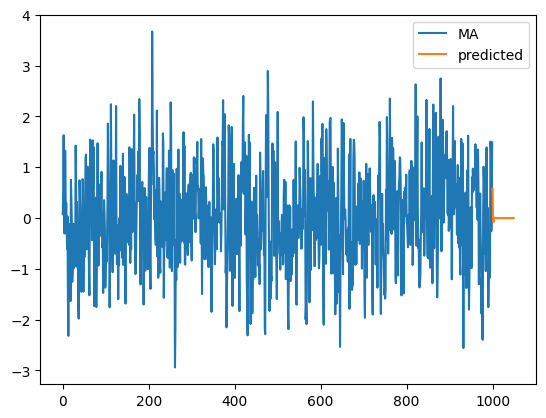

In [98]:
seed = 42
np.random.seed(seed)
coefs = np.array([0.9,0.4])
size = 1000

ma = generate_ma(coefs,sigma = 1, size = size)

model = MA(len(coefs))
model.fit(ma)


k = 50
predictions = model.predict(ma,k)

mse = np.mean((ma[-k:]-predictions)**2)

print("Estimated coefficients:\n", model.coefs)
print("Real coefficients\n", coefs)

print("MSE error on predictions:\n", mse)

plt.plot(np.arange(size), ma, label = "MA")
plt.plot(np.arange(size,size+k),predictions, label = "predicted")
plt.legend();









## Problem 4.  Stationarity for AR process [10 points]
It is known, that the AR(p) process defined by the equation of the form
$$
y_t = \phi_1 y_{t - 1} + \phi_2 y_{t - 2} + \ldots + \phi_p y_{t - p}.
$$
is weakly stationary if only if all roots of the regular characteristic polynomial have absolute values smaller than $1$.
The  regular characteristic polynomial has the form:
$$
R(\lambda) = \lambda^p - \phi_1 \lambda^{p - 1} - \ldots - \phi_p.
$$
Its roots are $\lambda_i$, $ i = 1, \ldots, p$. So, $\forall{i} \,\,  R(\lambda_i) = 0$.

Prove:
* Problem 4.1. [5 points] *Necessary condition:* If the process $AR(p)$ is weakly stationary, then $\sum_{i = 1}^p \phi_i < 1$.
* Problem 4.2. [5 points] *Sufficient condition:* If $\sum_{i = 1}^p |\phi_i| < 1$, then the corresponding process $AR(p)$ is weakly stationary.

## Problem 5. Gradient explosion* [20 points]

We consider a block in the recurrent neural network $h^t, x^t \in \mathbb{R}$:
$$
h^t = \phi(w_x x^t + w_h h^{t - 1} + b),
$$
where $\phi$ is the activation for the probit regression, CDF for the Gaussian distribution $\mathcal{N}(0, \sigma^2)$.
* Problem 5.1. [5 points] Find numerically or analytically (check, if possible) the expectation of the $\frac{\partial h^t}{\partial w_h}$ given $w_h \sim \mathcal{N}(0, \sigma^2)$.
* Problem 5.2. [5 points] Find numerically or analytically (check, if possible) the expectation of the $h^t$ given $w_h \sim \mathcal{N}(0, \sigma^2)$. In what cases we can get a stationary distribution for $h^t$?
* Problem 5.3. [10 points] Find the critical values for $\sigma^2$: in what case we'll have the explosion of the norm $\prod_{t = 1}^\infty \|\frac{\partial h^t}{\partial w_h} \| $? Provide numerical or analytical solution, if possible.